In [1]:
# --- IMPORT LIBRARIES ---
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
# --- SET PATHS ---
ref_path = r'D:\PhD\Aerial Data Processed\PGSP\DEM Raw\DEM_2020CLIP2.tif'
target_path = r'D:\PhD\Aerial Data Processed\PGSP\DEM Raw\DEM2022.tif'

corrected_output_path = r'D:\PhD\Aerial Data Processed\PGSP\DEM Processed\correctedDEM_2022.tif'
dod_output_path = r'D:\PhD\Aerial Data Processed\PGSP\DEM Processed\DoD_2022py.tif'

In [3]:
# --- SET XY SHIFT PARAMETERS ---
apply_xy_shift = True
dx_pixels = -2  # Shift left
dy_pixels = 3   # Shift down

# --- SET ELEVATION CORRECTION FUNCTION ---
def correct_elevation(dem):
    return 1.146 * dem - 0.6304


In [4]:
# --- STEP 1: LOAD DEMs ---
with rasterio.open(ref_path) as src_ref:
    ref = src_ref.read(1, masked=True)
    ref_profile = src_ref.profile
    ref_transform = src_ref.transform
    ref_crs = src_ref.crs
    ref_nodata = src_ref.nodata

with rasterio.open(target_path) as src_target:
    target = src_target.read(1, masked=True)
    target_profile = src_target.profile
    target_transform = src_target.transform
    target_crs = src_target.crs
    target_nodata = src_target.nodata


In [5]:
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject

# --- STEP 2: RESAMPLE TARGET DEM SAFELY ---

if ref.shape != target.shape or ref_crs != target_crs:
    print("Resampling target DEM to match reference DEM (streaming mode)...")
    
    resampled_target_path = r'D:\PhD\Aerial Data Processed\PGSP\DEM Raw\temp_resampled_target.tif'

    new_profile = ref_profile.copy()
    new_profile.update(dtype=rasterio.float32, nodata=-9999)

    with rasterio.open(target_path) as src:
        with rasterio.open(resampled_target_path, 'w', **new_profile) as dst:
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=ref_transform,
                dst_crs=ref_crs,
                resampling=Resampling.bilinear
            )

    # Now load the resampled raster as masked array
    with rasterio.open(resampled_target_path) as src:
        target = src.read(1, masked=True)
        target_profile = src.profile



Resampling target DEM to match reference DEM (streaming mode)...


In [6]:
# --- STEP 3: CREATE VALID MASK ---
valid_mask = (~target.mask) & (~ref.mask)

ref_masked = np.ma.array(ref, mask=~valid_mask)
target_masked = np.ma.array(target, mask=~valid_mask)

In [7]:
# --- STEP 4: Apply XY Shift (Efficient) ---
if apply_xy_shift:
    print(f"Applying XY shift: dx={dx_pixels}, dy={dy_pixels}")

    # Create a new masked array without allocating new big arrays
    shifted_data = np.full_like(target_masked.data, target_profile['nodata'], dtype=np.float32)
    shifted_mask = np.ones_like(target_masked.mask, dtype=bool)

    # Calculate valid slicing ranges
    src_y_start = max(0, -dy_pixels)
    src_y_end = target_masked.shape[0] - max(0, dy_pixels)
    src_x_start = max(0, -dx_pixels)
    src_x_end = target_masked.shape[1] - max(0, dx_pixels)

    dst_y_start = max(0, dy_pixels)
    dst_y_end = shifted_data.shape[0] - max(0, -dy_pixels)
    dst_x_start = max(0, dx_pixels)
    dst_x_end = shifted_data.shape[1] - max(0, -dx_pixels)

    # Shift both data and mask
    shifted_data[dst_y_start:dst_y_end, dst_x_start:dst_x_end] = target_masked.data[src_y_start:src_y_end, src_x_start:src_x_end]
    shifted_mask[dst_y_start:dst_y_end, dst_x_start:dst_x_end] = target_masked.mask[src_y_start:src_y_end, src_x_start:src_x_end]

    # Build shifted masked array
    target_masked = np.ma.array(shifted_data, mask=shifted_mask)


Applying XY shift: dx=-2, dy=3


In [8]:
# --- STEP 5: APPLY ELEVATION CORRECTION (Memory Efficient) ---

print("Applying elevation correction in chunks...")

# Prepare empty array for corrected DEM
target_corrected_data = np.empty_like(target_masked.data, dtype=np.float32)

# Define chunk size (adjust if needed)
chunk_size = 500 # number of rows per chunk

nrows = target_masked.shape[0]

for start_row in range(0, nrows, chunk_size):
    end_row = min(start_row + chunk_size, nrows)
    
    # Work on chunk
    chunk = target_masked.data[start_row:end_row, :]
    chunk_mask = target_masked.mask[start_row:end_row, :]

    # Apply correction only where not masked
    corrected_chunk = np.full_like(chunk, np.nan, dtype=np.float32)
    valid = ~chunk_mask
    corrected_chunk[valid] = 1.146 * chunk[valid] - 0.6304

    # Save corrected chunk
    target_corrected_data[start_row:end_row, :] = corrected_chunk

# Create masked array
target_corrected = np.ma.masked_array(target_corrected_data, mask=target_masked.mask)

print("Elevation correction completed.")

Applying elevation correction in chunks...
Elevation correction completed.


In [9]:
# --- STEP 6: CALCULATE DEM OF DIFFERENCE (DoD) ---
dod = target_corrected - ref_masked

In [10]:
# --- STEP 7: SAVE CORRECTED TARGET DEM and DOD ---
new_profile = ref_profile.copy()
new_profile.update(dtype=rasterio.float32, nodata=-9999)

with rasterio.open(corrected_output_path, 'w', **new_profile) as dst:
    dst.write(target_corrected.filled(-9999).astype(np.float32), 1)

with rasterio.open(dod_output_path, 'w', **new_profile) as dst:
    dst.write(dod.filled(-9999).astype(np.float32), 1)

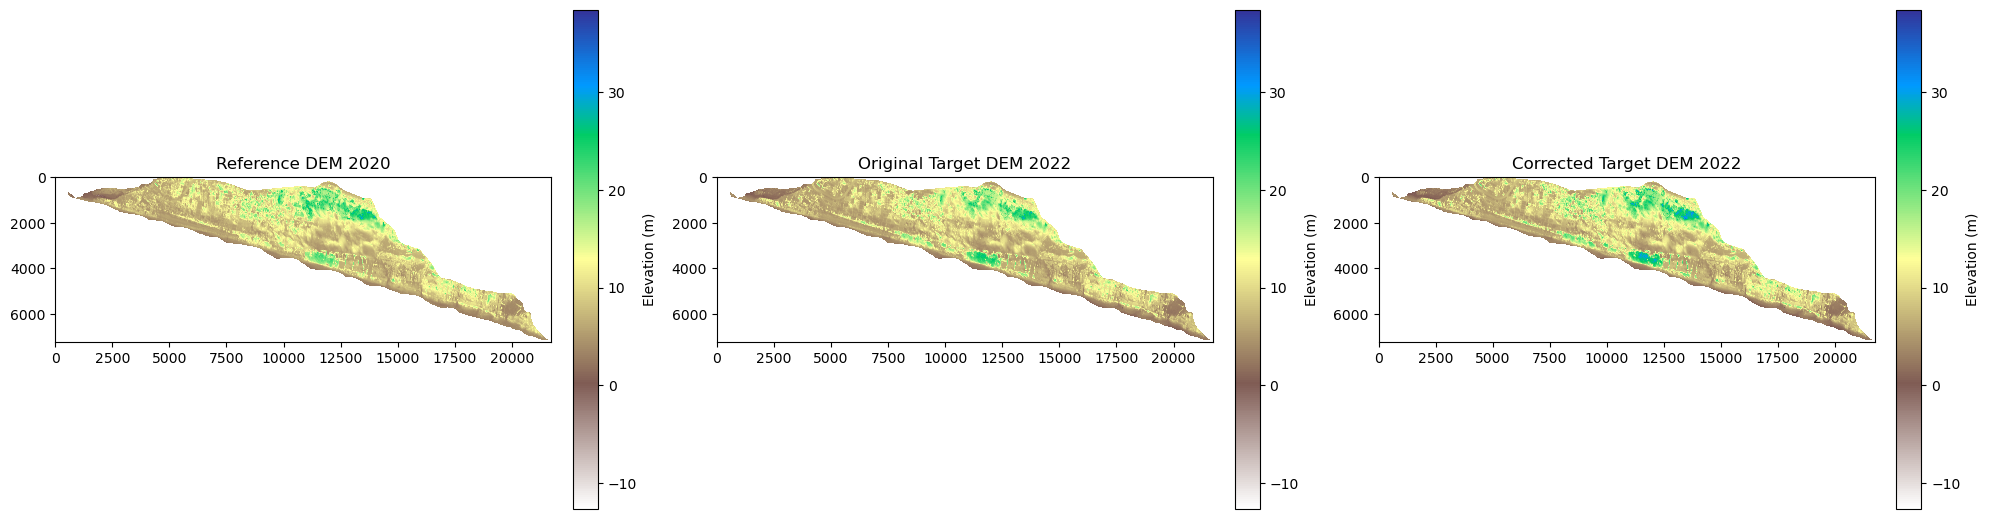

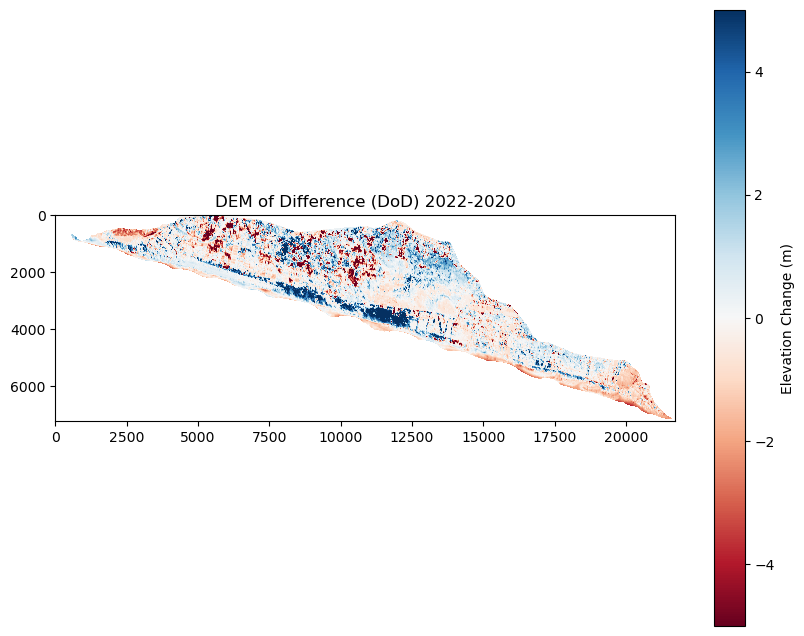

In [11]:
# --- STEP 8: PLOT RESULTS ---
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

vmin = min(ref_masked.min(), target_masked.min(), target_corrected.min())
vmax = max(ref_masked.max(), target_masked.max(), target_corrected.max())

cmap = plt.cm.terrain_r  # blue low, brown/white high

im1 = axs[0].imshow(ref_masked, cmap=cmap, vmin=vmin, vmax=vmax)
axs[0].set_title('Reference DEM 2020')
fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04, label='Elevation (m)')

im2 = axs[1].imshow(target_masked, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].set_title('Original Target DEM 2022')
fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04, label='Elevation (m)')

im3 = axs[2].imshow(target_corrected, cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].set_title('Corrected Target DEM 2022')
fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04, label='Elevation (m)')

plt.tight_layout()
plt.show()

# Plot DoD separately
plt.figure(figsize=(10, 8))
dod_plot = plt.imshow(dod, cmap='RdBu', vmin=-5, vmax=5)
plt.colorbar(dod_plot, label='Elevation Change (m)')
plt.title('DEM of Difference (DoD) 2022-2020')
plt.show()

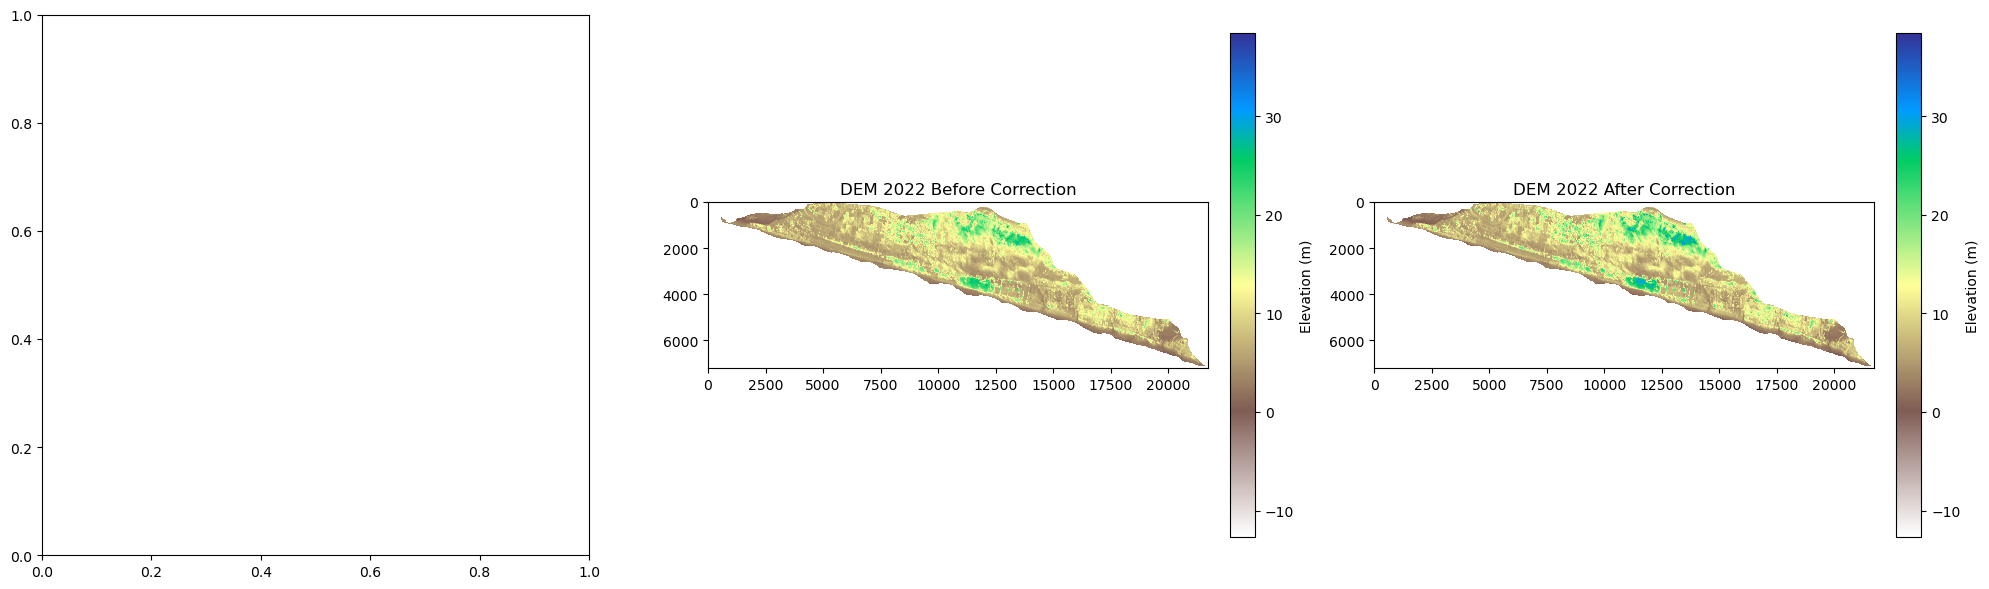

In [12]:
# --- STEP 8: PLOT RESULTS ---
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

vmin = min(ref_masked.min(), target_masked.min(), target_corrected.min())
vmax = max(ref_masked.max(), target_masked.max(), target_corrected.max())

cmap = plt.cm.terrain_r  # blue low, brown/white high

im1 = axs[1].imshow(target_masked, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].set_title('DEM 2022 Before Correction')
fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04, label='Elevation (m)')

im2 = axs[2].imshow(target_corrected, cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].set_title('DEM 2022 After Correction')
fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04, label='Elevation (m)')

plt.tight_layout()
plt.show()
